# Data Modelling
## Using Classification algorithm 
#### Decision tree, Random Forrest, XGB, Naive Bayer, Logistic Regression

<br><br>
In the previous python file, we already clean and preprocess our data. Now, we want to build classification model using Decision Tree, Random Forrest, XGB, Naive Bayes, And Logistic Regression. <br><br>

**In general what we want to do in this file :**

<br>

1. Import necesary modules and df3.csv which is data clean_tweet that already been cleaned
2. Sampling the data, use only 7% as we see using all data, it take to long to compute. We sugested using server or using PYSPARK, MAPREDUCE in hadoop, and others to distributed jobs to servers
3. use TFID vectorizer to change from text into numeric. Notes that we use TFID as it's using weight in frequent words, rather than just changing the frequency in countvectorizer
4. build train test split
5. Build classification model, comparing the recall, precision, and f1score
6. Optional
    - Build clasification model by removing words that is appear in both sentiments
    - Build clasification model by using typo correction (textblob) *notes : we only use 0.1% data as it takes to long to compute textblob*
    


<br><br>
### 1. Importing necessary modules and data

<br><br>
Notes, that we can use many algorithm like MLPclasiffier, KNN, SVC and many more. But, there are computationaly expensive and it takes to long to train the model. So we use faster algorithm.

In [30]:
# Import necesary modules for data
import pandas as pd
import numpy as np

# Classifier Model

# from sklearn.neural_network import MLPClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
# from sklearn.gaussian_process import GaussianProcessClassifier
# from sklearn.gaussian_process.kernels import RBF
# from sklearn.naive_bayes import GaussianNB
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


#import sklearn preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

#import sklearn for model evaluation 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#import visualization module 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS



#import textblob 
from textblob import TextBlob

In [4]:
df4 = pd.read_csv('df3.csv').drop(columns=['Unnamed: 0'])
print(df4.shape)
df4=df4.dropna()
df4.head()

(1596753, 2)


,text,target
0,awww bummer shoulda get david carr third day,0
1,upset update facebook texting might cry result...,0
2,dive many time ball manage save rest go bound,0
3,whole body feel itchy like fire,0
4,behave mad see,0


<br><br>
We drop unnamed:0 as it is automaticaly create when we export to csv. We see that our data already been cleaned (no stopwords, base verb)

In [5]:
df4.tail()

,text,target
1596748,wake school best feel ever,1
1596749,thewdb com cool hear old walt interview bmta,1
1596750,ready mojo makeover ask detail,1
1596751,happy th birthday boo alll time tupac amaru sh...,1
1596752,happy charitytuesday,1


## 2. Sampling Data

<br><br>
We use 7% data, as we see it's best to represent the population. We insist to run original data when we already have access to server as it takes to much computing power using our laptop. 

In [6]:
pos=df4[df4['target']==1]
neg=df4[df4['target']==0]
pos_sampling = pos.sample(frac=0.07).reset_index().drop(columns='index')
neg_sampling = neg.sample(frac=0.07).reset_index().drop(columns='index')

print(pos_sampling.shape)
print(neg_sampling.shape)
pos_sampling.head()


(55716, 2)
(55741, 2)


,text,target
0,leesh rabena haykrdmak ataba gdeda least still...,1
1,du sk welcome twitter hj rtat,1
2,raymo heyy reply follow thanxx,1
3,thank happy finally decent hours word since,1
4,boo boo commin today,1


<br><br>
As you can see, our data is balanced. We append both sentiment and create split train test in the next part

In [7]:
data2=pd.DataFrame()
data2=pos_sampling.append(neg_sampling,ignore_index=True)

data2['target'].value_counts()

0    55741
1    55716
Name: target, dtype: int64

<br><br>

## 3. TFID vectorizer

<br>
We are using TFID vectorizer instead of count vectorizer. The reason why, you can see in this link <br>

https://www.quora.com/What-is-the-difference-between-TfidfVectorizer-and-CountVectorizer-1

<br>
Which roughly says :<br>

"**CountVectorizer** *just counts the word frequencies. Simple as that. With the **TFIDFVectorizer** the value increases proportionally to count, but is offset by the frequency of the word in the corpus. - This is the IDF (inverse document frequency part). This helps to adjust for the fact that some words appear more frequently. How often do you really use crepuscular, and petrichor? <br>
Sure, they are important words, and should be used when appropriate, but how often do we really use them?<br>
Without the inverse document frequency part commen, less meaning giving words such as “the” (assuming you don’t filter stopwords) would bear a higher weight than these less frequent words."*

<br>
On overall, as you can see in those links, TFID is used more when building machine learning model

<br><br>
Before, we split our data to prediction X, and target, Y


In [57]:
# Train test split
X = data2['text']
y = data2['target']

In [58]:
y.value_counts()

0    55741
1    55716
Name: target, dtype: int64

In [59]:
#tfidf vectorizer
tfidf=TfidfVectorizer()
X_vecto = tfidf.fit_transform(X)
X_vecto

<111457x50815 sparse matrix of type '<class 'numpy.float64'>'
	with 750887 stored elements in Compressed Sparse Row format>

## 4. Train test split

<br><br>
We use 80% train and 20% test. 

In [60]:
#train test split using tfidfvectorizer 
xtrain,xtest, ytrain , ytest = train_test_split(X_vecto, y, test_size=0.2, random_state=0)

## 5. Model Development

<br><br>
We are, as we stated before using Decision tree, random forrest, XGB, MultinomialNB, and Logistic Regression. We choose which models produced the best f1score, precision, and Recall. 
<br><br>
Decision Tree, basicaly means we split data into more and more homogenous leaf nodes. <br>
"**A decision tree** *is a decision support tool that uses a tree-like graph or model of decisions and their possible consequences, including chance event outcomes, resource costs, and utility. It is one way to display an algorithm that only contains conditional control statements.<br>
A decision tree is a flowchart-like structure in which each internal node represents a “test” on an attribute (e.g. whether a coin flip comes up heads or tails), each branch represents the outcome of the test, and each leaf node represents a class label (decision taken after computing all attributes). The paths from root to leaf represent classification rules.<br>
Tree based learning algorithms are considered to be one of the best and mostly used supervised learning methods. Tree based methods empower predictive models with high accuracy, stability and ease of interpretation. Unlike linear models, they map non-linear relationships quite well. They are adaptable at solving any kind of problem at hand (classification or regression)*"

<br>

"*Boosting is based on weak learners (high bias, low variance). In terms of decision trees, weak learners are shallow trees, sometimes even as small as decision stumps (trees with two leaves). Boosting reduces error mainly by reducing bias (and also to some extent variance, by aggregating the output from many models).<br>
On the other hand, Random Forest uses as you said fully grown decision trees (low bias, high variance). It tackles the error reduction task in the opposite way: by reducing variance. The trees are made uncorrelated to maximize the decrease in variance, but the algorithm cannot reduce bias (which is slightly higher than the bias of an individual tree in the forest). Hence the need for large, unpruned trees, so that the bias is initially as low as possible.*"

<br>
Naive bayes, bassicaly using Bayesian Theorem to produce given predictor X, which class it belongs to. Regression Logistic in the other hands, are regression but using logit function as expecation of random variable respon (Y). 

<br>
<br>
Other than above machine Learning, we use these statistics to measure our model performance :
<br>

**Accuracy** - Accuracy is the most intuitive performance measure and it is simply a ratio of correctly predicted observation to the total observations. One may think that, if we have high accuracy then our model is best. Yes, accuracy is a great measure but only when you have symmetric datasets where values of false positive and false negatives are almost same. Therefore, you have to look at other parameters to evaluate the performance of your model
<br>
**Precision** - Precision is the ratio of correctly predicted positive observations to the total predicted positive observations. The question that this metric answer is of all data that labeled (by model) as positive, how many actually positive? High precision relates to the low false positive rate. 
<br>
**Recall (Sensitivity)** - Recall is the ratio of correctly predicted positive observations to the all observations in actual class - yes. The question recall answers is: Of all the data that truly positive, how many did we label?  
<br>
**F1 score** - F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. Intuitively it is not as easy to understand as accuracy, but F1 is usually more useful than accuracy, especially if you have an uneven class distribution. Accuracy works best if false positives and false negatives have similar cost. If the cost of false positives and false negatives are very different, it’s better to look at both Precision and Recall.

<br>
Ideally, we see the confusion matrix of both models and AUC score. But, we use these 3 statistics to first determine which model works best for our data

In [63]:
# The resulted model performance will be stored here
Result = pd.DataFrame(columns=['model','train_accuracy','test_accuracy','train_recall','test_recall','train_precision','test_precision','train_f1','test_f1'])

# Initialize 
j=0

# Classifiers and its names
classifiers=[DecisionTreeClassifier(max_depth=30),RandomForestClassifier(max_depth=30),XGBClassifier(),MultinomialNB(),LogisticRegression()]
names = ["Decision Tree", "Random Forest", "XGB",'MultinomialNB','LogisticRegression']

# iteration on each models
for model in classifiers:
    
    model=model.fit(xtrain,ytrain)    
    predict_train = model.predict(xtrain)
    predict_test = model.predict(xtest)

    accuracy_train=accuracy_score(ytrain, predict_train)
    accuracy_test=accuracy_score(ytest, predict_test)
    recall_train = recall_score(ytrain, predict_train, average="micro")
    recall_test = recall_score(ytest, predict_test,average="micro") 

    precision_train = precision_score(ytrain, predict_train,average="micro")
    precision_test = precision_score(ytest, predict_test,average="micro")

    f1score_train = f1_score(ytrain, predict_train,average="micro")
    f1score_test = f1_score(ytest, predict_test,average="micro")
    
    # The produced score resulted here temporary
    Re=pd.DataFrame()
    
    
    Re['model']=[names[j]]
    
    Re['train_accuracy'] =  [accuracy_train]
    Re['test_accuracy'] =  [accuracy_test]
    Re['train_recall'] =  [recall_train]
    Re['test_recall'] =  [recall_test]
    Re['train_precision'] =  [precision_train]
    Re['test_precision'] =  [precision_test]
    Re['train_f1'] =  [f1score_train]
    Re['test_f1'] =  [f1score_test]
    
    # append the result to Resull table
    Result = Result.append(Re,ignore_index=True)
    j+=1   
    
Result   

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


,model,train_accuracy,test_accuracy,train_recall,test_recall,train_precision,test_precision,train_f1,test_f1
0,Decision Tree,0.697191,0.650772,0.697191,0.650772,0.697191,0.650772,0.697191,0.650772
1,Random Forest,0.712533,0.674906,0.712533,0.674906,0.712533,0.674906,0.712533,0.674906
2,XGB,0.686446,0.680199,0.686446,0.680199,0.686446,0.680199,0.686446,0.680199
3,MultinomialNB,0.825683,0.741566,0.825683,0.741566,0.825683,0.741566,0.825683,0.741566
4,LogisticRegression,0.813245,0.762650,0.813245,0.762650,0.813245,0.762650,0.813245,0.762650


<br><br>
Turns out, logistic regression produced best result with f1score, precision, recall the highest. With all statistic measurement 0.765, this means roughly our models roughly be able to labeled the data test correctly 76,5%, which is quite high. It means, compared to just predict blindly, which have probability correct 50%, our model has biggher probability correct, which is 76.5% or 1.5 times higher than using blind luck.

In [84]:
from sklearn.metrics import confusion_matrix 

# the last iteration is logistic regression so we didn't need to rerun our model
results = confusion_matrix(ytest, predict_test,labels=[0,1])  
print('     Confussion Matrix')
print('\n')
print(pd.DataFrame(results,columns=['Actual 0','Actual 1'],index=['Predicted 0','Predicted 1']))

     Confussion Matrix


             Actual 0  Actual 1
Predicted 0      8238      2968
Predicted 1      2323      8763


<br><br>
Looking at confussion matrix, we can further see our model performance. For example, in columns Actual 1, our model correctly predicted 1 8763 times, and 2968 times incorrectly predicted 0 when it actualy 1. Our model good enough to predicted sentiment analysis.

### Conclusion  and Recomendation:

<br><br>
Using Logistic regression, we can predicted and classify if user tweet classify as positive (1) or negative (0)  by analyzing each words in those tweets and put it in regression model (after cleaning and count vectorizer). With accuracy (and others measurement) 76.5%, our model is good enough.
<br>
**recomendation** <br>
We can use more data tweets, to be able to further analyze population. If you do not want to wait all day running the model, you can use distribution jobs to another server by using pyspark, hadoop (map reduce) etc. Here, we only demonstrate our model development to sentiment analysis

# OPTIONAL

## Improve Logistic Models
<br>
<br>
Logistic regression, can be improved by inputting relevant features (or X) in columns as it was for example insignificant or does not have strong relationship with Y. This means in our analysis we can remove unecessary words. Notice that some words is contained in both positive and negative. We will show this by using world cloud

In [87]:
#define happy and not happy 
happy = data2[data2['target'] == 1]
not_happy  = data2[data2['target'] == 0]

In [88]:
#merge all the happy comments into one paragraph
all_description_happy = "".join(happy.text.values)
all_description_not_happy = "".join(not_happy.text.values)

In [89]:
#text = happy.Description
#make a wordcloud 
def create_word_cloud(string):
    cloud = WordCloud(background_color = "white", max_words = 30, stopwords = set(STOPWORDS)).generate(string)
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

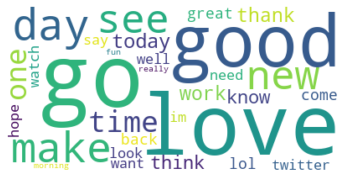

In [90]:
#happy 
create_word_cloud(all_description_happy)

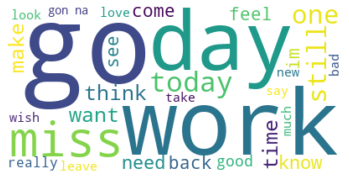

In [91]:
#nothappy
create_word_cloud(all_description_not_happy)

<br><br>
For example, **go**, **day**, etc contained in both positive and negative. This means this words in doesnot unique in each sentiment, and only create confusion in our models. If **go** happens in both sentiment, then if there are user tweets that contains **go** our model will incorectly classify it. Of course, we have to consider collinearity (which is **go** could be correlated to other words which even if it violates regression assumption, it can still improve our model). For now, we want to compare the result when we run logistic regression but by removing same words in each sentiment

In [92]:
hap=happy['text'].value_counts()
hap.head()

thank                                                                    274
good morning                                                              81
get followers day use www tweeteradder com add everyone train pay vip     66
welcome                                                                   48
love                                                                      43
Name: text, dtype: int64

In [93]:
n_hap=not_happy['text'].value_counts()
n_hap.head()

miss                               62
work                               56
lose please help find good home    40
headache                           40
sad                                31
Name: text, dtype: int64

In [95]:
delete_word=[]
for i in hap.index:
    if str(i) in str(n_hap.index):
        delete_word.append(i)
print(len(delete_word))
print(delete_word[:10])


55
['know', 'good', 'work', 'hi', 'go', 'home', 'check', 'miss', 'think', 'happy']


<br>
These are words that contained in each sentiment. There are 55 words for example, 'go','work','hi' etc. We remove all same words within our data and tried to rerun our logistic models

In [96]:
data3=data2.copy()
data3['text'] = data3['text'].apply(lambda x: " ".join(x for x in x.split() if x not in delete_word))
data3['text'].head()


0    leesh rabena haykrdmak ataba gdeda least still...
1                                du sk welcome hj rtat
2                             raymo heyy follow thanxx
3                thank finally decent hours word since
4                                               commin
Name: text, dtype: object

In [97]:
# Train test split
X = data3['text']
y = data3['target']

In [98]:
y.value_counts()

0    55741
1    55716
Name: target, dtype: int64

In [99]:
#tfidf vectorizer
tfidf=TfidfVectorizer()
X_vecto = tfidf.fit_transform(X)
X_vecto

<111457x50766 sparse matrix of type '<class 'numpy.float64'>'
	with 661703 stored elements in Compressed Sparse Row format>

In [100]:
#train test split using tfidfvectorizer 
xtrain,xtest, ytrain , ytest = train_test_split(X_vecto, y, test_size=0.2, random_state=0)

In [103]:
model = LogisticRegression()
model=model.fit(xtrain,ytrain)    
predict_train = model.predict(xtrain)
predict_test = model.predict(xtest)

accuracy_train=accuracy_score(ytrain, predict_train)
accuracy_test=accuracy_score(ytest, predict_test)
recall_train = recall_score(ytrain, predict_train, average="micro")
recall_test = recall_score(ytest, predict_test,average="micro") 
precision_train = precision_score(ytrain, predict_train,average="micro")
precision_test = precision_score(ytest, predict_test,average="micro")

f1score_train = f1_score(ytrain, predict_train,average="micro")
f1score_test = f1_score(ytest, predict_test,average="micro")

Re=pd.DataFrame()
Re['model']=['Logistic Regression Improved']

Re['train_accuracy'] =  [accuracy_train]
Re['test_accuracy'] =  [accuracy_test]
Re['train_recall'] =  [recall_train]
Re['test_recall'] =  [recall_test]
Re['train_precision'] =  [precision_train]
Re['test_precision'] =  [precision_test]
Re['train_f1'] =  [f1score_train]
Re['test_f1'] =  [f1score_test]

Result = Result.append(Re,ignore_index=True)


Result   

,model,test_accuracy,test_f1,test_precision,test_recall,train_accuracy,train_f1,train_precision,train_recall
0,Decision Tree,0.650772,0.650772,0.650772,0.650772,0.697191,0.697191,0.697191,0.697191
1,Random Forest,0.674906,0.674906,0.674906,0.674906,0.712533,0.712533,0.712533,0.712533
2,XGB,0.680199,0.680199,0.680199,0.680199,0.686446,0.686446,0.686446,0.686446
3,MultinomialNB,0.741566,0.741566,0.741566,0.741566,0.825683,0.825683,0.825683,0.825683
4,LogisticRegression,0.762650,0.762650,0.762650,0.762650,0.813245,0.813245,0.813245,0.813245
5,Logistic Regression Improved,0.737798,0.737798,0.737798,0.737798,0.801581,0.801581,0.801581,0.801581


<br><br>
Looks like our model is suprisingly decreasing in validation measurement. Then it's best to not remove any words. This as we stated above could be the result og multicollinearity, that is some deleted words have corellation with other words which by removing it makes the correlation of Predictor Y from that other words decrease

## Other Optional, Using Logistic Regression on Corrected Typo Data

<br><br>
We use 0.1% of our data to fix typo in data. We are using TEXTBLOB and it takes a long time to compute. Because of it, we sugested to using MAPREDUCE in server (or using PYSPARK or others distributed jobs architecture) if you want to fix typos

In [104]:
pos=df4[df4['target']==1]
neg=df4[df4['target']==0]
pos_sampling = pos.sample(frac=0.001).reset_index().drop(columns='index')
neg_sampling = neg.sample(frac=0.001).reset_index().drop(columns='index')

print(pos_sampling.shape)
print(neg_sampling.shape)
pos_sampling.head()


(796, 2)
(796, 2)


,text,target
0,thank already round tummy,1
1,trafalgar square get vote,1
2,way go,1
3,dich teach kid roleplay natural,1
4,faulty penis freak lol thejlu,1


In [105]:
data10=pd.DataFrame()
data10=pos_sampling.append(neg_sampling,ignore_index=True)

data10['target'].value_counts()

1    796
0    796
Name: target, dtype: int64

<br><br>
You see that we only used 1400 data from total 1.6m data. It's not the representation of those 1.6m, but we only want to compare the result

In [41]:
data10['text']=data10['text'].apply(lambda x: str(TextBlob(x).correct()))

<br><br>
Because it's take to long to run above code, we export to csv those corrected typo data so we won't have to run above code again

In [45]:
data10['target']=pos_sampling.append(neg_sampling,ignore_index=True)['target']
#data10.to_csv('data_fix_typo.csv')
data10.head()

,target,text
0,1,glad know pay bill go walk st apt
1,1,hata up around think
2,1,yes sir look extremely good make look younger
3,1,blush
4,1,havana ameeeeei love


<br><br>
Imported those corrected typo data 

In [50]:
data10=pd.read_csv('data_fix_typo.csv').drop(columns=["Unnamed: 0"])
data10.head()

,target,text
0,1,glad know pay bill go walk st apt
1,1,hata up around think
2,1,yes sir look extremely good make look younger
3,1,blush
4,1,havana ameeeeei love


In [107]:
X=data10['text']
y=data10['target']
y.value_counts()

1    796
0    796
Name: target, dtype: int64

In [108]:
#tfidf vectorizer
tfidf=TfidfVectorizer()
X_vecto = tfidf.fit_transform(X)
X_vecto

<1592x3515 sparse matrix of type '<class 'numpy.float64'>'
	with 10628 stored elements in Compressed Sparse Row format>

In [109]:
#train test split using tfidfvectorizer 
xtrain,xtest, ytrain , ytest = train_test_split(X_vecto, y, test_size=0.2, random_state=0)

In [111]:
model = LogisticRegression()
model=model.fit(xtrain,ytrain)    
predict_train = model.predict(xtrain)
predict_test = model.predict(xtest)

accuracy_train=accuracy_score(ytrain, predict_train)
accuracy_test=accuracy_score(ytest, predict_test)
recall_train = recall_score(ytrain, predict_train, average="micro")
recall_test = recall_score(ytest, predict_test,average="micro") 
precision_train = precision_score(ytrain, predict_train,average="micro")
precision_test = precision_score(ytest, predict_test,average="micro")

f1score_train = f1_score(ytrain, predict_train,average="micro")
f1score_test = f1_score(ytest, predict_test,average="micro")

Re=pd.DataFrame()
Re['model']=['Logistic Regression Improved Typo']

Re['train_accuracy'] =  [accuracy_train]
Re['test_accuracy'] =  [accuracy_test]
Re['train_recall'] =  [recall_train]
Re['test_recall'] =  [recall_test]
Re['train_precision'] =  [precision_train]
Re['test_precision'] =  [precision_test]
Re['train_f1'] =  [f1score_train]
Re['test_f1'] =  [f1score_test]

Result = Result.append(Re,ignore_index=True)


Result   

,model,test_accuracy,test_f1,test_precision,test_recall,train_accuracy,train_f1,train_precision,train_recall
0,Decision Tree,0.650772,0.650772,0.650772,0.650772,0.697191,0.697191,0.697191,0.697191
1,Random Forest,0.674906,0.674906,0.674906,0.674906,0.712533,0.712533,0.712533,0.712533
2,XGB,0.680199,0.680199,0.680199,0.680199,0.686446,0.686446,0.686446,0.686446
3,MultinomialNB,0.741566,0.741566,0.741566,0.741566,0.825683,0.825683,0.825683,0.825683
4,LogisticRegression,0.762650,0.762650,0.762650,0.762650,0.813245,0.813245,0.813245,0.813245
5,Logistic Regression Improved,0.737798,0.737798,0.737798,0.737798,0.801581,0.801581,0.801581,0.801581
6,Logistic Regression Improved Typo,0.633229,0.633229,0.633229,0.633229,0.934014,0.934014,0.934014,0.934014


<br><br>
Our model is more worsen using this corected typo when we validate our model to measurement. But, you see that in train, our model has improved (even almost perfect) measurement score. This means, our models can predict well train data, but cannot predict test data. This could be caused by using only some tiny3x fraction of our data, and the sample (and train) cannot represent the original data well enough. We insist and sugested using corected typo to bigger size data

## Conclusion #2 OPTIONAL (SEE ABOVE CONCLUSION IF YOU JUST SKIP TO LAST CELL)

<br>
Looks like it's bet to just use original data, as it has better measurement score than removing some match column between sentiment and by  typo correction (but we still not sure as the train accuracy is highly improved). 

##### Created By : Andreas Mulyarahardja